In [5]:
# Importing Libraries and all dependicies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from prophet import Prophet
import calendar
import random

plt.style.use("seaborn-v0_8-whitegrid")


DATE_DAYFIRST = True

In [6]:

# Load the Walmart sales dataset from CSV
df = pd.read_csv("Walmart_Sales.csv")

# Since the dataset utilizes the DD-MM-YYYY format, convert the Date column to a correct datetime format (dayfirst=True).
df["Date"] = pd.to_datetime(df["Date"], dayfirst=DATE_DAYFIRST)

# Reset the index to maintain cleanliness
# Sort the dataset so that each store's sales display in chronological order.
df = df.sort_values(["Store", "Date"]).reset_index(drop=True)

# Print the dataset's basic information:
# - the total number of rows and columns
# - the allowed date range
# - a list of all column names
# - the number of missing data in each column
print("Shape:", df.shape)
print("Date range:", df["Date"].min().date(), "→", df["Date"].max().date())
print("Columns:", list(df.columns))
print("NA counts:\n", df.isna().sum())

# Store 36 contains inconsistent or corrupted records in this dataset,
# so we remove it to prevent errors and model instability during analysis.
df = df[df["Store"] != 36].reset_index(drop=True)


Shape: (6435, 8)
Date range: 2010-02-05 → 2012-10-26
Columns: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
NA counts:
 Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [7]:


# Extract ISO calendar components from the Date column.
# This helps models capture seasonality patterns such as weekly and yearly trends.
iso = df["Date"].dt.isocalendar()

# Year the sale occurred (useful for long-term trends)
df["Year"] = iso.year.astype(int)

# Month number (captures monthly seasonality effects)
df["Month"] = df["Date"].dt.month

# ISO week number (captures weekly seasonality)
df["Week"] = iso.week.astype(int)

# Store a cleaner name for week-of-year for convenience
df["WeekOfYear"] = df["Week"]


# Create a table listing major U.S. retail-impact holidays across 2010–2012.
# Each entry includes:
#   - holiday name
#   - year
#   - the starting Friday of the holiday week in the Walmart dataset
holiday_rows = [
    ("SuperBowl", 2010, "2010-02-05"),
    ("SuperBowl", 2011, "2011-02-04"),
    ("SuperBowl", 2012, "2012-02-03"),
    ("LaborDay", 2010, "2010-09-03"),
    ("LaborDay", 2011, "2011-09-02"),
    ("LaborDay", 2012, "2012-08-31"),
    ("Thanksgiving", 2010, "2010-11-19"),
    ("Thanksgiving", 2011, "2011-11-18"),
    ("BlackFriday", 2010, "2010-11-26"),
    ("BlackFriday", 2011, "2011-11-25"),
    ("Christmas", 2010, "2010-12-24"),
    ("Christmas", 2011, "2011-12-23"),
]

# Convert this list into a DataFrame for merging
holiday_df = pd.DataFrame(holiday_rows, columns=["Holiday_Name", "Year", "Holiday_WeekStart"])
holiday_df["Holiday_WeekStart"] = pd.to_datetime(holiday_df["Holiday_WeekStart"])

# Merge the holiday information with the main dataset.
# If the Date matches a holiday week-start, the corresponding holiday name appears.
df = df.merge(
    holiday_df[["Holiday_Name", "Holiday_WeekStart"]],
    left_on="Date",
    right_on="Holiday_WeekStart",
    how="left"
)

# Create a simple binary indicator: 1 if the date is an official holiday week, else 0.
df["fixed_holiday_flag"] = df["Holiday_Name"].notna().astype(int)

# Replace missing holiday names with "No Holiday" for interpretability
df["Holiday_Name"] = df["Holiday_Name"].fillna("No Holiday")

# Remove the merge helper column
df = df.drop(columns=["Holiday_WeekStart"])



# Easter dates for each year
# Easter drives seasonal shopping behavior (clothing, candy, decorations)
easter_weeks = pd.to_datetime(["2010-04-02", "2011-04-22", "2012-04-06"])
df["Easter_Flag"] = df["Date"].isin(easter_weeks).astype(int)

# IRS tax refund weeks — many consumers spend tax refunds on retail purchases
tax_refund_weeks = pd.to_datetime(["2011-02-18", "2012-02-17"])
df["TaxRefund_Flag"] = df["Date"].isin(tax_refund_weeks).astype(int)

# July 4 shopping events (summer season, BBQ, outdoor items)
july4_weeks = pd.to_datetime(["2010-07-02", "2011-07-01", "2012-06-29"])
df["July4_Flag"] = df["Date"].isin(july4_weeks).astype(int)

# Back-to-school season — strong effects on clothing, stationery, school supplies
back_to_school_weeks = pd.to_datetime(["2010-09-10", "2011-09-09", "2012-09-07"])
df["BackToSchool_Flag"] = df["Date"].isin(back_to_school_weeks).astype(int)

# Create a feature for the 3 weeks leading up to Christmas
# (This period historically has very high sales spikes)
christmas_weeks = pd.to_datetime(["2010-12-24", "2011-12-23"])

# Generate the 1–3 weeks before each Christmas date
leadup_weeks = [c - pd.Timedelta(weeks=i) for c in christmas_weeks for i in range(1, 4)]
leadup_weeks = pd.to_datetime(leadup_weeks)

# Flag whether the current week is part of the Christmas lead-up period
df["Christmas_Leadup"] = df["Date"].isin(leadup_weeks).astype(int)


Randomly selected store: 26


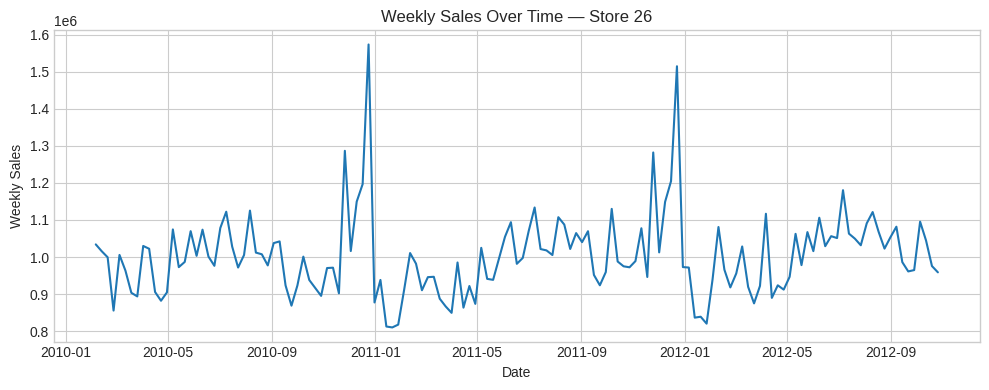

Holiday lift (any holiday) Store 26: 7.45%


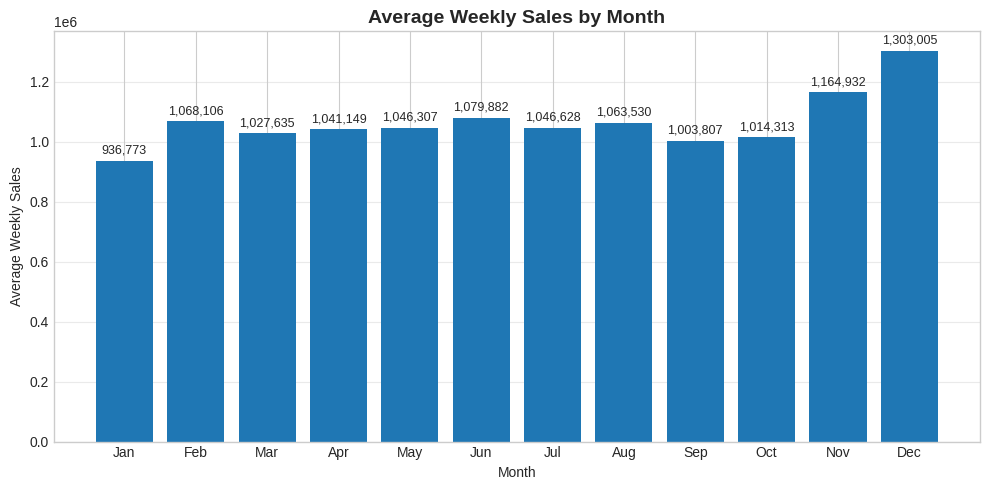

In [9]:

# Select one store at random so we can see how it behaves.
 # (Optional: use random.seed(123) to set a manual seed for repeatability.)
 # random.seed (123)
store_id = random.choice(df["Store"].unique())
print(f"Randomly selected store: {store_id}")

# Filter the data for the chosen store and keep only the columns we need.
# We sort by date so the time-series plot is in proper chronological order.
s = (df.loc[df["Store"] == store_id, ["Date", "Weekly_Sales", "Holiday_Flag"]]
     .sort_values("Date")
     .reset_index(drop=True))

# Plot weekly sales over time for this store.
# This helps us visually inspect trends, spikes, and any strange behaviour.
plt.figure(figsize=(10, 4))
plt.plot(s["Date"], s["Weekly_Sales"])
plt.title(f"Weekly Sales Over Time — Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.tight_layout()
plt.show()

# Average sales during holiday weeks (Holiday_Flag = 1)
avg_holiday = s.loc[s["Holiday_Flag"] == 1, "Weekly_Sales"].mean()

# Average sales during non-holiday weeks (Holiday_Flag = 0)
avg_nonhol = s.loc[s["Holiday_Flag"] == 0, "Weekly_Sales"].mean()

# Percentage lift: how much higher holiday sales are compared to normal weeks
lift_allhol = 100 * (avg_holiday - avg_nonhol) / avg_nonhol
print(f"Holiday lift (any holiday) Store {store_id}: {lift_allhol:.2f}%")

# ----------------------------------------------------------

#1) Seasonality curve by week of the year
 # Determine the average weekly sales for all stores for each week number (1–53).
 #  This displays the weeks of the year when sales are usually at their highest or lowest.
seasonality = (df.groupby("WeekOfYear")["Weekly_Sales"]
               .mean()
               .reindex(range(1, 54)))   # ensure full range 1–53

plt.figure(figsize=(12, 5))
plt.plot(seasonality.index, seasonality.values)
plt.title("Seasonality Pattern: Average Weekly Sales by Week of Year")
plt.xlabel("Week of Year")
plt.ylabel("Average Weekly Sales")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Monthly seasonality (bar chart)
# Compute the average weekly sales for each month across the dataset.
avg_by_month = (df.groupby("Month")["Weekly_Sales"]
                .mean()
                .reindex(range(1, 13)))   # months 1–12 in order

# Use short month names (Jan, Feb, ...) for the x-axis labels.
month_labels = [calendar.month_abbr[m] for m in range(1, 13)]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(month_labels, avg_by_month.values)

ax.set_title("Average Weekly Sales by Month", fontsize=14, fontweight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Average Weekly Sales")
ax.grid(True, axis="y", alpha=0.4)

# Annotate each bar with the exact average value (rounded to nearest integer).
for bar, val in zip(bars, avg_by_month.values):
    ax.annotate(f"{val:,.0f}",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 5),
                textcoords="offset points",
                ha="center",
                fontsize=9)

plt.tight_layout()
plt.show()


In [10]:
# ----------------------------------------------------------
# Economic features and their relationship with weekly sales
# ----------------------------------------------------------

# Make sure the dataset is arranged by store and date before calculating changes over time
# so that rolling averages and differences accurately reflect chronological movement.
df = df.sort_values(["Store", "Date"])

# Create week-to-week change (delta) features for key economic variables.
# These capture short-term movements that might influence sales behavior.
df["Delta_Fuel"] = df["Fuel_Price"].diff()
df["Delta_CPI"] = df["CPI"].diff()
df["Delta_Unemp"] = df["Unemployment"].diff()
df["Delta_Temp"] = df["Temperature"].diff()

# Calculate rolling averages for economic variables for a period of four weeks.
# Rolling windows help catch medium-term economic trends that might affect consumer buying and smooth out noisy variations.
df["Fuel_4wk"] = df["Fuel_Price"].rolling(4).mean()
df["Unemp_4wk"] = df["Unemployment"].rolling(4).mean()
df["CPI_4wk"] = df["CPI"].rolling(4).mean()
df["Temp_4wk"] = df["Temperature"].rolling(4).mean()

# List of raw economic variables to examine.
econ_cols = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

# Compute simple Pearson correlations between weekly sales and each
# economic variable. This gives an initial indication of whether
# economic conditions move together with weekly sales.
print(df[["Weekly_Sales"] + econ_cols].corr()["Weekly_Sales"])

# ----------------------------------------------------------
# Visualizing economic relationships with scatter plots
# ----------------------------------------------------------

# To see how weekly sales
# connect to each economic statistic, create a 2x2 grid of scatter plots.  This aids in determining if the
# connection exhibits any discernible patterns, is linear, weak, or noisy.
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axes.ravel(), econ_cols):
    ax.scatter(df[col], df["Weekly_Sales"], s=5)
    ax.set_title(f"Weekly Sales vs {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Weekly Sales")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Weekly_Sales    1.000000
Temperature    -0.049452
Fuel_Price      0.002082
CPI            -0.043981
Unemployment   -0.110796
Name: Weekly_Sales, dtype: float64


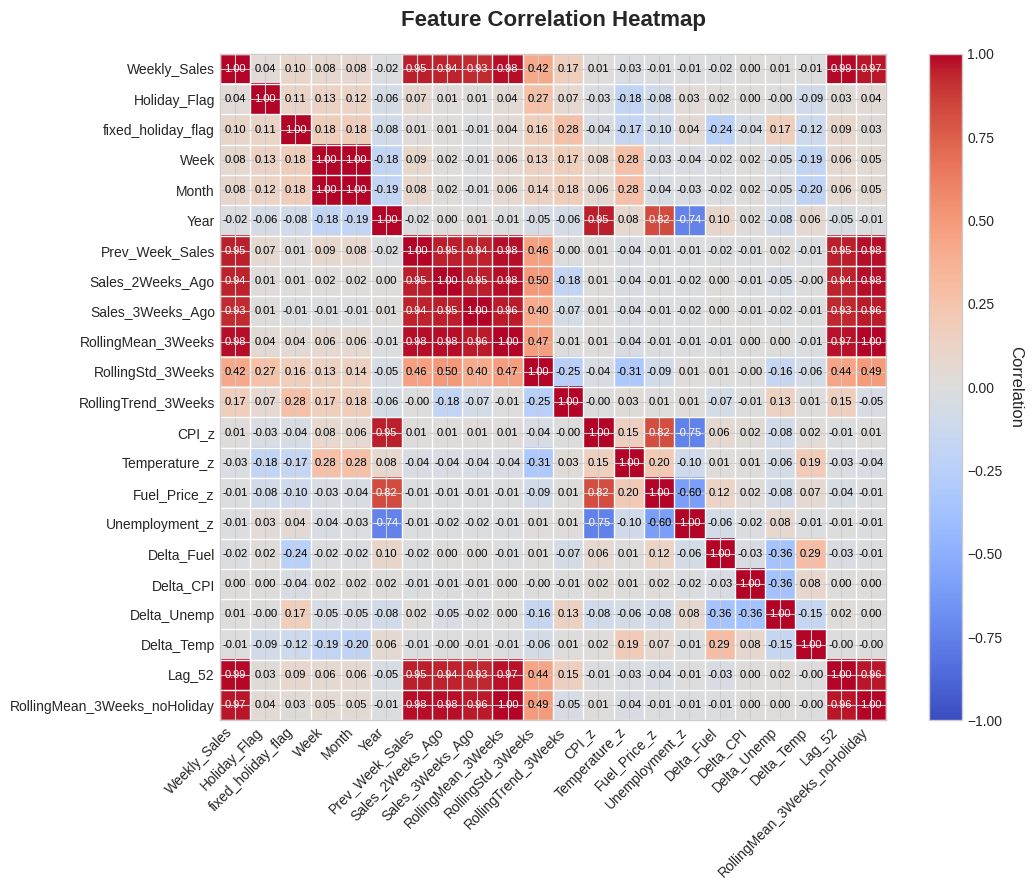

In [11]:
# 9. Lag and rolling features

# Sort by store and date so that lags and rolling windows follow true time order
df = df.sort_values(["Store", "Date"])

# Group weekly sales by store to create store-specific lag and rolling features
grp = df.groupby("Store")["Weekly_Sales"]

# Lag features: previous 1, 2, and 3 weeks of sales for each store
df["Prev_Week_Sales"] = grp.shift(1)
df["Sales_2Weeks_Ago"] = grp.shift(2)
df["Sales_3Weeks_Ago"] = grp.shift(3)

# Alternative names for the first two lags (kept for clarity and consistency)
df["Lag_1"] = df["Prev_Week_Sales"]
df["Lag_2"] = df["Sales_2Weeks_Ago"]

# One-year seasonal lag: sales from 52 weeks ago (same week last year)
df["Lag_52"] = grp.shift(52)

# A tool for estimating a straightforward short-term trend over a brief period of time.
# It returns the slope after fitting a line to the final few locations.
def rolling_trend(x):
    if len(x) < 3:
        return np.nan
    y = np.arange(len(x))
    return np.cov(y, x)[0, 1] / np.var(y)

# Rolling 3-week mean: smooths short-term noise in weekly sales
df["RollingMean_3Weeks"] = (
    grp.rolling(3, min_periods=1)
       .mean()
       .reset_index(level=0, drop=True)
)

# Rolling 3-week standard deviation: measures short-term volatility in sales
df["RollingStd_3Weeks"] = (
    grp.rolling(3, min_periods=1)
       .std()
       .reset_index(level=0, drop=True)
)

# Rolling 3-week trend: slope of sales over the last 3 weeks
df["RollingTrend_3Weeks"] = (
    grp.rolling(3, min_periods=3)
       .apply(rolling_trend, raw=False)
       .reset_index(level=0, drop=True)
)

# Holiday-aware rolling mean: 3-week average that excludes holiday weeks,
# so we can capture "normal" baseline demand without holiday spikes.
def holiday_aware_roll(series, flag, window=3):
    vals = []
    for i in range(len(series)):
        start = max(0, i - window + 1)
        # Exclude weeks where Holiday_Flag is True within the window
        window_vals = series[start:i + 1][~flag[start:i + 1].astype(bool)]
        vals.append(window_vals.mean() if len(window_vals) > 0 else np.nan)
    return pd.Series(vals, index=series.index)

df["RollingMean_3Weeks_noHoliday"] = (
    df.groupby("Store", group_keys=False)[["Weekly_Sales", "Holiday_Flag"]]
      .apply(lambda s: holiday_aware_roll(s["Weekly_Sales"], s["Holiday_Flag"], 3))
)

# For every store, standardize key continuous variables.   This puts CPI,
# temperature, gas prices, and unemployment on a single scale (mean 0, standard deviation 1) to avoid models being dominated by units.
scaled_cols = ["CPI", "Temperature", "Fuel_Price", "Unemployment"]
for sid, sub in df.groupby("Store"):
    scaler = StandardScaler()
    df.loc[sub.index, [c + "_z" for c in scaled_cols]] = scaler.fit_transform(sub[scaled_cols])

# Build a list of features to include in the correlation matrix
corr_cols = [
    "Weekly_Sales", "Holiday_Flag", "fixed_holiday_flag",
    "Week", "Month", "Year",
    "Prev_Week_Sales", "Sales_2Weeks_Ago", "Sales_3Weeks_Ago",
    "RollingMean_3Weeks", "RollingStd_3Weeks", "RollingTrend_3Weeks",
    "CPI_z", "Temperature_z", "Fuel_Price_z", "Unemployment_z",
    "Delta_Fuel", "Delta_CPI", "Delta_Unemp", "Delta_Temp",
    "Lag_52", "RollingMean_3Weeks_noHoliday"
]

# Keep only the columns that actually exist in the DataFrame
corr_cols = [c for c in corr_cols if c in df.columns]

# Compute the correlation matrix for the selected features
corr = df[corr_cols].corr()

# Plot a heatmap of feature correlations to understand how inputs
# relate to Weekly_Sales and to each other.
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

plt.title("Feature Correlation Heatmap", fontsize=16, pad=20, fontweight="bold")

# Add colorbar with label
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom", fontsize=12)

# Set tick labels
ax.set_xticks(np.arange(len(corr_cols)))
ax.set_yticks(np.arange(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(corr_cols, fontsize=10)

# Draw grid lines between cells
ax.set_xticks(np.arange(-0.5, len(corr_cols), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(corr_cols), 1), minor=True)
ax.grid(which="minor", color="w", linestyle="-", linewidth=1.0)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate each cell in the heatmap with the numerical correlation value
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        v = corr.iloc[i, j]
        ax.text(
            j, i, f"{v:.2f}",
            ha="center", va="center",
            color="black" if abs(v) < 0.7 else "white",
            fontsize=8
        )

plt.tight_layout()
plt.show()


In [12]:
# Clean modeling dataset (drop rows without full lag/rolling info)
df_clean = df.dropna(subset=[
    "Prev_Week_Sales", "Sales_2Weeks_Ago", "Sales_3Weeks_Ago",
    "RollingMean_3Weeks", "RollingStd_3Weeks", "RollingTrend_3Weeks"
])
print("Original rows:", len(df), "Cleaned rows:", len(df_clean))

Original rows: 6292 Cleaned rows: 6160


In [13]:

# To forecast, choose one store at random.
# (Optional: specify random.seed for repeatability) # random.seed(123)
store_id = random.choice(df_clean["Store"].unique())
print(f"Using Store {store_id}")

# Create a time-series DataFrame for the selected store.
# Set Date as the index and ensure values are ordered chronologically.
store_df = (
    df_clean[df_clean["Store"] == store_id][["Date", "Weekly_Sales"]]
    .sort_values("Date")
    .set_index("Date")
)

# Convert the data to a weekly frequency (Friday-based), which aligns
# with Walmart’s reporting structure in the dataset.
store_df = store_df.asfreq("W-FRI").dropna(subset=["Weekly_Sales"])

# h is the forecast horizon (10 future weeks)
h = 10

# Split into training data (all but last 10 weeks)
# and testing data (the final 10 weeks)
train, test = store_df.iloc[:-h], store_df.iloc[-h:]


# Automatically fit a seasonal ARIMA model.
 #  Important factors:
 # - seasonal=True, m=52 -> weekly data with annual seasonality
 #-test='adf' => stationarity tests-based automated differencing
 #-restricted p, q, P, Q ranges → lowers the complexity of the search
 #-information_criterion='aicc' → works better with smaller datasets
arima_model = auto_arima(
    train["Weekly_Sales"],
    d=None, test="adf",
    seasonal=True, m=52,
    D=None,
    start_p=1, start_q=1,
    start_P=0, start_Q=0,
    max_p=2, max_q=2, max_P=2, max_Q=2,
    stepwise=True,
    information_criterion="aicc",
    suppress_warnings=True,
    trace=True
)

# Print the ARIMA model summary (order, coefficients, diagnostics)
print(arima_model.summary())

# Forecast the next h weeks using the fitted model
arima_forecast = pd.Series(
    arima_model.predict(n_periods=h),
    index=test.index,
    name="ARIMA"
)

# Compute evaluation metrics: RMSE and MAE
rmse_arima = sqrt(mean_squared_error(test["Weekly_Sales"], arima_forecast))
mae_arima = mean_absolute_error(test["Weekly_Sales"], arima_forecast)


Using Store 2
Performing stepwise search to minimize aicc
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AICC=3582.915, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AICC=3599.564, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AICC=3559.647, Time=7.94 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AICC=3558.035, Time=1.53 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AICC=4135.400, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AICC=3587.665, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AICC=3559.859, Time=2.45 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AICC=3554.114, Time=8.13 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AICC=3556.113, Time=24.66 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AICC=3559.810, Time=4.36 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AICC=3544.568, Time=22.49 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AICC=3549.351, Time=1.19 sec
 ARIMA(1,0,1)(1,0,2)[52] intercept   : AICC=3545.975, Time=12.58 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AICC=3545.575, T

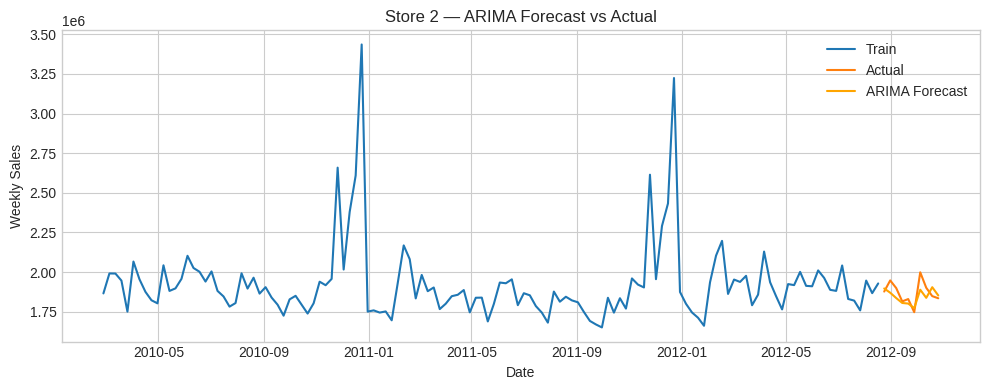

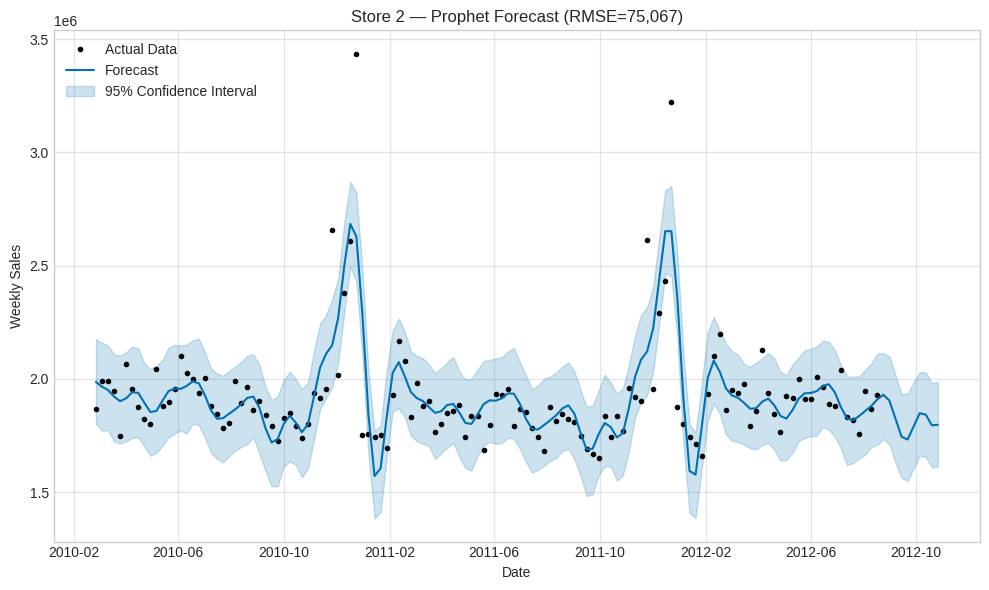

In [14]:
# Prepare data for Prophet: it expects columns named 'ds' (date) and 'y' (target)
prophet_df = store_df.reset_index().rename(columns={"Date": "ds", "Weekly_Sales": "y"})

# Split into training and testing sets using the same horizon h
train_p, test_p = prophet_df.iloc[:-h], prophet_df.iloc[-h:]

# Set up the Prophet model.
# Since the series is weekly, we disable daily seasonality and activate weekly and annual seasonality, which are pertinent to this data.
m = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=False
)

# Fit Prophet on the training data
m.fit(train_p)

# Create a future dataframe that extends the training dates by h weeks
future = m.make_future_dataframe(periods=h, freq="W-FRI")

# Generate forecasts for the full period (train + h future points)
forecast_p = m.predict(future)

# Extract only the last h weeks of Prophet predictions that align with the test set
prophet_forecast = (
    forecast_p.set_index("ds")
              .loc[test.index, "yhat"]
              .rename("Prophet")
)

# Evaluate Prophet forecasts using RMSE and MAE
rmse_prophet = sqrt(mean_squared_error(test["Weekly_Sales"], prophet_forecast))
mae_prophet = mean_absolute_error(test["Weekly_Sales"], prophet_forecast)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(train.index, train["Weekly_Sales"], label="Train")
plt.plot(test.index, test["Weekly_Sales"], label="Actual")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="orange")
plt.title(f"Store {store_id} — ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()

# Plottinhg the full promphet
# -------------------------------------------------------------------
fig1 = m.plot(forecast_p)
plt.title(f"Store {store_id} — Prophet Forecast (RMSE={rmse_prophet:,.0f})")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
# Prophet's plot already includes forecast and confidence band; we label them here
plt.legend(["Actual Data", "Forecast", "95% Confidence Interval"], loc="upper left")
plt.tight_layout()
plt.show()

# Combine actuals and both model forecasts into one DataFrame
# for easier side-by-side comparison and export if needed
compare_df = pd.concat(
    [
        test["Weekly_Sales"].rename("Actual"),
        arima_forecast,
        prophet_forecast
    ],
    axis=1
)



Model Performance Comparison:


RMSE           MAE
Model                              
ARIMA    56147.345905  47163.885024
Prophet  75067.224623  67948.571860

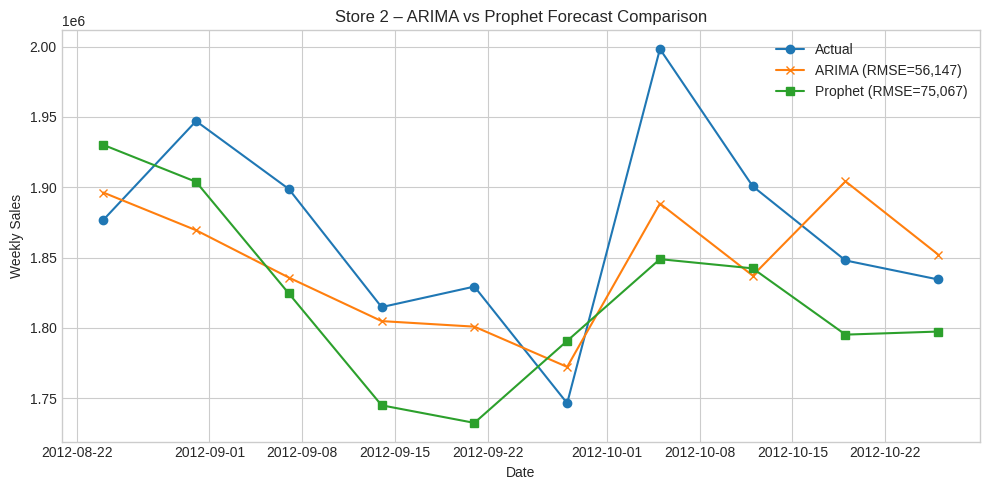


Model Interpretation:
For Store 2, ARIMA achieved lower RMSE and MAE, indicating stronger predictive accuracy.
Prophet explicitly models trend and seasonality (and can incorporate holiday effects),while ARIMA relies on past sales dynamics and autocorrelation.Comparing the two helps us understand how much of Walmart's weekly sales can be captured by classical time-series structure versus an explicit trend/seasonality model.


In [16]:
# Create a small summary table comparing ARIMA and Prophet on RMSE and MAE
metrics = pd.DataFrame({
    "Model": ["ARIMA", "Prophet"],
    "RMSE": [rmse_arima, rmse_prophet],
    "MAE": [mae_arima, mae_prophet]
}).set_index("Model")

print("\nModel Performance Comparison:")
display(metrics)

# Plot actual values and both model forecasts on the same chart for visual comparison
plt.figure(figsize=(10, 5))
plt.plot(compare_df.index, compare_df["Actual"], label="Actual", marker="o")
plt.plot(
    compare_df.index,
    compare_df["ARIMA"],
    label=f"ARIMA (RMSE={rmse_arima:,.0f})",
    marker="x"
)
plt.plot(
    compare_df.index,
    compare_df["Prophet"],
    label=f"Prophet (RMSE={rmse_prophet:,.0f})",
    marker="s"
)

plt.title(f"Store {store_id} – ARIMA vs Prophet Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()

# Identify which model performed better based on RMSE
better = "Prophet" if rmse_prophet < rmse_arima else "ARIMA"

# Print a brief interpretation of the comparison
print("\nModel Interpretation:")
print(f"For Store {store_id}, {better} achieved lower RMSE and MAE, indicating stronger predictive accuracy.")
print(
    "Prophet explicitly models trend and seasonality (and can incorporate holiday effects)," "while ARIMA relies on past sales dynamics and autocorrelation."
     "Comparing the two helps us understand how much of Walmart's weekly sales can be captured by classical time-series structure versus an explicit trend/seasonality model." )


## XG Boost implemenation

In [25]:
feature_cols = [
    "Week", "Month", "Year",
    "Holiday_Flag", "fixed_holiday_flag",
    "Prev_Week_Sales", "Sales_2Weeks_Ago", "Sales_3Weeks_Ago", "Lag_52",
    "RollingMean_3Weeks", "RollingStd_3Weeks", "RollingTrend_3Weeks",
    "CPI_z", "Temperature_z", "Fuel_Price_z", "Unemployment_z"
]

# keep only columns that actually exist (safety)
feature_cols = [c for c in feature_cols if c in df_clean.columns]
print("Using features:", feature_cols)


Using features: ['Week', 'Month', 'Year', 'Holiday_Flag', 'fixed_holiday_flag', 'Prev_Week_Sales', 'Sales_2Weeks_Ago', 'Sales_3Weeks_Ago', 'Lag_52', 'RollingMean_3Weeks', 'RollingStd_3Weeks', 'RollingTrend_3Weeks', 'CPI_z', 'Temperature_z', 'Fuel_Price_z', 'Unemployment_z']


In [26]:
store_ml = df_clean[df_clean["Store"] == store_id].copy()
store_ml = store_ml.sort_values("Date")

print("Store {} rows for ML: {}".format(store_id, len(store_ml)))


Store 22 rows for ML: 140


In [27]:
split_date = pd.to_datetime("2012-01-01")

train_ml = store_ml[store_ml["Date"] < split_date].copy()
test_ml = store_ml[store_ml["Date"] >= split_date].copy()

print("Train rows:", len(train_ml), "Test rows:", len(test_ml))


Train rows: 97 Test rows: 43


In [28]:
X_train = train_ml[feature_cols]
y_train = train_ml["Weekly_Sales"]

X_test = test_ml[feature_cols]
y_test = test_ml["Weekly_Sales"]


In [29]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]


In [30]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [31]:
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"\n XGBoost performance for Store {store_id}:")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAE:  {mae_xgb:,.2f}")



 XGBoost performance for Store 22:
RMSE: 41,147.23
MAE:  31,203.25


In [32]:
plt.figure(figsize=(12, 5))

plt.plot(train_ml["Date"], train_ml["Weekly_Sales"], label="Train Actual", alpha=0.6)
plt.plot(test_ml["Date"], y_test, label="Test Actual", linewidth=2)
plt.plot(test_ml["Date"], y_pred_xgb, label="XGBoost Predicted", linewidth=2, linestyle="--")

plt.title(f"Store {store_id} — XGBoost Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
all_models_table = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "XGBoost"],
    "RMSE": [rmse_arima, rmse_prophet, rmse_xgb],
    "MAE":  [mae_arima, mae_prophet, mae_xgb]
})

print("\n Model Comparison (Store {}):".format(store_id))
print(all_models_table)



 Model Comparison (Store 22):
     Model          RMSE           MAE
0    ARIMA  43615.626595  37141.418606
1  Prophet  40426.939685  27848.532157
2  XGBoost  41147.231968  31203.246512


## LSTM

In [62]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf


# Use the same store ID as the ARIMA/Prophet section for fair comparison
store_id_lstm = store_id   # or set manually, e.g. store_id_lstm = 4

# Select weekly sales for the chosen store and sort by date
store_series = (
    df_clean[df_clean["Store"] == store_id_lstm]
    .sort_values("Date")[["Date", "Weekly_Sales"]]
    .dropna()
    .reset_index(drop=True)
)

print(f"Store {store_id_lstm} rows for LSTM:", len(store_series))

# Extract date and target arrays
dates_all = store_series["Date"].values
y_all_raw = store_series["Weekly_Sales"].astype("float32").values.reshape(-1, 1)

# Scale the target (Weekly_Sales) into [0, 1] so that the LSTM
# can train more stably and does not struggle with large values.
scaler_y = MinMaxScaler()
y_all_scaled = scaler_y.fit_transform(y_all_raw).flatten()

SEQ_LEN = 4  # number of past weeks used as input

X_seq = []
y_seq = []
dates_seq = []

# For each position i, use the previous SEQ_LEN weeks to predict week i
for i in range(SEQ_LEN, len(y_all_scaled)):
    X_seq.append(y_all_scaled[i-SEQ_LEN:i])  # past SEQ_LEN weeks (scaled)
    y_seq.append(y_all_scaled[i])            # current week's (scaled) sales
    dates_seq.append(dates_all[i])           # date associated with the target

# Convert lists to NumPy arrays and reshape for LSTM input
X_seq = np.array(X_seq, dtype="float32")     # shape: (samples, SEQ_LEN)
X_seq = X_seq[..., np.newaxis]              # shape: (samples, SEQ_LEN, 1)
y_seq = np.array(y_seq, dtype="float32")
dates_seq = np.array(dates_seq)

print("LSTM sequence data shape:", X_seq.shape, y_seq.shape)


# Use 2012-01-01 as the cut-off between training and testing
split_date = np.datetime64("2012-01-01")

train_mask = dates_seq < split_date
test_mask  = dates_seq >= split_date

X_train_lstm = X_seq[train_mask]
y_train_lstm = y_seq[train_mask]
X_test_lstm  = X_seq[test_mask]
y_test_lstm  = y_seq[test_mask]
dates_test_lstm = dates_seq[test_mask]

print("Train:", X_train_lstm.shape, y_train_lstm.shape)
print("Test :", X_test_lstm.shape, y_test_lstm.shape)

# Sanity checks to ensure there are no missing values going into the model
print("Any NaNs in X_train_lstm?", np.isnan(X_train_lstm).any())
print("Any NaNs in y_train_lstm?", np.isnan(y_train_lstm).any())
print("Any NaNs in X_test_lstm?", np.isnan(X_test_lstm).any())
print("Any NaNs in y_test_lstm?", np.isnan(y_test_lstm).any())

# Clear any existing TensorFlow graph to avoid conflicts
tf.keras.backend.clear_session()

n_features = 1  # univariate input (only Weekly_Sales)

# Define a simple LSTM model:
# - One LSTM layer with 32 units
# - One Dense output layer predicting the next week's sales (scaled)
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(SEQ_LEN, n_features)))
lstm_model.add(Dense(1))

# Use mean squared error loss and Adam optimizer
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.summary()

# Train the model on the training sequences, using 10% of the training
# data as a validation set to monitor performance during training.
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Generate predictions on the test set (still in scaled units)
y_pred_scaled = lstm_model.predict(X_test_lstm).flatten()

# Convert both predictions and true values back to the original
# sales scale using the inverse transform of the scaler.
y_true = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Compute RMSE and MAE in the original Weekly_Sales units
rmse_lstm = sqrt(mean_squared_error(y_true, y_pred))
mae_lstm  = mean_absolute_error(y_true, y_pred)

print(f"\nUnivariate LSTM performance for Store {store_id_lstm}:")
print(f"RMSE: {rmse_lstm:,.2f}")
print(f"MAE:  {mae_lstm:,.2f}")

plt.figure(figsize=(12, 5))
plt.plot(dates_test_lstm, y_true, label="Actual", linewidth=2)
plt.plot(dates_test_lstm, y_pred, label="LSTM Predicted", linestyle="--", linewidth=2)
plt.title(f"Store {store_id_lstm} — Univariate LSTM Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


Store 22 rows for LSTM: 140
LSTM sequence data shape: (136, 4, 1) (136,)
Train: (93, 4, 1) (93,)
Test : (43, 4, 1) (43,)
Any NaNs in X_train_lstm? False
Any NaNs in y_train_lstm? False
Any NaNs in X_test_lstm? False
Any NaNs in y_test_lstm? False


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - loss: 0.0678 - val_loss: 0.2221
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0558 - val_loss: 0.1985
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0582 - val_loss: 0.1769
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0385 - val_loss: 0.1574
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0293 - val_loss: 0.1396
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0257 - val_loss: 0.1232
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0291 - val_loss: 0.1083
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0258 - val_loss: 0.0955
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0250 - val_loss: 0.0846
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0193 - val_loss: 0.0763
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0182 - val_loss: 0.0706
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0176 - val_loss: 0.0665


In [40]:

# Evaluating Models
all_models_table = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "XGBoost", "LSTM"],
    "RMSE": [rmse_arima, rmse_prophet, rmse_xgb, rmse_lstm],
    "MAE":  [mae_arima, mae_prophet, mae_xgb, mae_lstm]
})

print("\n Model Comparison (Store {}):".format(store_id))
print(all_models_table)



 Model Comparison (Store 22):
     Model          RMSE           MAE
0    ARIMA  43615.626595  37141.418606
1  Prophet  40426.939685  27848.532157
2  XGBoost  41147.231968  31203.246512
3     LSTM  90722.466280  61871.226562


In [41]:
store_ml      # df_clean filtered to that store, sorted by Date
train_ml      # rows before 2012-01-01
test_ml       # rows on/after 2012-01-01

X_train, y_train, X_test, y_test  # used for XGBoost
y_pred_xgb                         # XGBoost predictions on X_test


array([1005945.1 ,  914262.2 ,  926640.  ,  910210.94,  947291.2 ,
       1009743.94,  981734.94,  947003.56,  973192.9 ,  969120.  ,
        963035.  ,  970047.6 ,  965795.8 , 1159452.6 ,  994423.9 ,
       1074484.  ,  939445.7 ,  992690.2 ,  999881.94,  959884.7 ,
       1006336.3 , 1075753.1 , 1049221.6 , 1041199.25, 1041360.94,
       1047493.4 , 1041397.6 , 1004715.9 ,  959672.44,  943446.94,
        979106.8 ,  977771.4 ,  962192.75, 1011915.6 ,  975324.2 ,
        970495.25,  953802.75,  931975.6 ,  965015.5 ,  992911.75,
        982800.5 ,  976486.4 , 1031949.44], dtype=float32)

In [42]:
# Make sure test_ml is sorted by Date and matches y_test, y_pred_xgb
test_ml = test_ml.sort_values("Date").copy()

# If not already aligned, align y_test and y_pred_xgb with test_ml index
y_test_aligned = y_test.loc[test_ml.index]
y_pred_aligned = pd.Series(y_pred_xgb, index=test_ml.index, name="XGB_Pred")

# Add predictions & residuals to test_ml
test_ml["Pred_XGB"] = y_pred_aligned
test_ml["Residual"] = test_ml["Weekly_Sales"] - test_ml["Pred_XGB"]

print(test_ml[["Date", "Weekly_Sales", "Pred_XGB", "Residual"]].head())


           Date  Weekly_Sales      Pred_XGB     Residual
3103 2012-01-06     895358.20  1.005945e+06 -110586.9250
3104 2012-01-13     855437.57  9.142622e+05  -58824.6175
3105 2012-01-20     897027.44  9.266400e+05  -29612.5600
3106 2012-01-27     786459.23  9.102109e+05 -123751.7075
3107 2012-02-03     958487.75  9.472912e+05   11196.5625


In [43]:
res_mean = test_ml["Residual"].mean()
res_std  = test_ml["Residual"].std()

test_ml["Residual_z"] = (test_ml["Residual"] - res_mean) / res_std
test_ml["Anomaly_z"] = (test_ml["Residual_z"].abs() > 3).astype(int)  # |z| > 3

print(test_ml[["Date", "Weekly_Sales", "Pred_XGB", "Residual", "Residual_z", "Anomaly_z"]]
      .head(10))


           Date  Weekly_Sales      Pred_XGB     Residual  Residual_z  \
3103 2012-01-06     895358.20  1.005945e+06 -110586.9250   -2.735509   
3104 2012-01-13     855437.57  9.142622e+05  -58824.6175   -1.488926   
3105 2012-01-20     897027.44  9.266400e+05  -29612.5600   -0.785417   
3106 2012-01-27     786459.23  9.102109e+05 -123751.7075   -3.052554   
3107 2012-02-03     958487.75  9.472912e+05   11196.5625    0.197383   
3108 2012-02-10    1034448.07  1.009744e+06   24704.1325    0.522683   
3109 2012-02-17    1004749.41  9.817349e+05   23014.4725    0.481991   
3110 2012-02-24     912958.95  9.470036e+05  -34044.6125   -0.892153   
3111 2012-03-02     974866.65  9.731929e+05    1673.7750   -0.031953   
3112 2012-03-09     991127.01  9.691200e+05   22007.0100    0.457729   

      Anomaly_z  
3103          0  
3104          0  
3105          0  
3106          1  
3107          0  
3108          0  
3109          0  
3110          0  
3111          0  
3112          0  


In [44]:
plt.figure(figsize=(12, 5))

plt.plot(test_ml["Date"], test_ml["Weekly_Sales"], label="Actual Sales", linewidth=2)

# highlight anomaly points
anoms = test_ml[test_ml["Anomaly_z"] == 1]
plt.scatter(anoms["Date"], anoms["Weekly_Sales"], color="red", label="Anomaly (|z|>3)", zorder=5)

plt.title(f"Store {store_id} — Weekly Sales with Z-score Anomalies")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    contamination=0.05,
    random_state=42
)

# Fit on residuals (reshape to 2D)
iso.fit(test_ml[["Residual"]])

# predict: -1 = anomaly, 1 = normal
test_ml["Anomaly_IF"] = iso.predict(test_ml[["Residual"]])
test_ml["Anomaly_IF"] = test_ml["Anomaly_IF"].map({1: 0, -1: 1})  # convert to 0/1

print(test_ml[["Date", "Weekly_Sales", "Residual", "Anomaly_IF"]].head())


           Date  Weekly_Sales     Residual  Anomaly_IF
3103 2012-01-06     895358.20 -110586.9250           1
3104 2012-01-13     855437.57  -58824.6175           0
3105 2012-01-20     897027.44  -29612.5600           0
3106 2012-01-27     786459.23 -123751.7075           1
3107 2012-02-03     958487.75   11196.5625           0


In [46]:
plt.figure(figsize=(12, 5))

plt.plot(test_ml["Date"], test_ml["Weekly_Sales"], label="Actual Sales", linewidth=2)

anoms_if = test_ml[test_ml["Anomaly_IF"] == 1]
plt.scatter(anoms_if["Date"], anoms_if["Weekly_Sales"],
            color="purple", label="IsolationForest Anomaly", zorder=5)

plt.title(f"Store {store_id} — Weekly Sales with IsolationForest Anomalies")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [47]:
from sklearn.linear_model import LinearRegression

promo_cols = ["Holiday_Flag", "Fuel_Price", "CPI", "Unemployment"]
promo_cols = [c for c in promo_cols if c in store_ml.columns]

print("Using promo features:", promo_cols)

X_promo = store_ml[promo_cols].copy()
y_promo = store_ml["Weekly_Sales"].copy()

linreg = LinearRegression()
linreg.fit(X_promo, y_promo)

print("\nLinear Regression coefficients:")
for col, coef in zip(promo_cols, linreg.coef_):
    print(f"{col:15s} -> {coef:,.2f}")

print("Intercept:", linreg.intercept_)


Using promo features: ['Holiday_Flag', 'Fuel_Price', 'CPI', 'Unemployment']

Linear Regression coefficients:
Holiday_Flag    -> 63,097.34
Fuel_Price      -> -52,801.66
CPI             -> 9,405.84
Unemployment    -> 29,413.40
Intercept: -338224.74881041795


In [48]:
from sklearn.ensemble import RandomForestRegressor
import shap

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_promo, y_promo)

# Global feature importances from RF
importances = pd.Series(rf_model.feature_importances_, index=promo_cols).sort_values(ascending=False)
print("\nRandom Forest feature importances:")
print(importances)



Random Forest feature importances:
Fuel_Price      0.484341
CPI             0.285291
Unemployment    0.201978
Holiday_Flag    0.028389
dtype: float64


In [49]:
# Create a small sample for SHAP if data is large
X_sample = X_promo.sample(min(2000, len(X_promo)), random_state=42)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")


## Week 6

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# if not already imported:
# from scipy.interpolate import UnivariateSpline

# Choose a store (you can fix it instead of random)
store_id_poly = df_clean["Store"].unique()[0]   # or pick a number manually
print("Using store for Week 6:", store_id_poly)

store_ts = (df_clean[df_clean["Store"] == store_id_poly]
            .sort_values("Date")
            .reset_index(drop=True)[["Date", "Weekly_Sales"]])

print(store_ts.head())

# Create x = 0,1,2,... as time index
x = np.arange(len(store_ts))
y = store_ts["Weekly_Sales"].values

dates = store_ts["Date"].values


Using store for Week 6: 1
        Date  Weekly_Sales
0 2010-02-26    1409727.59
1 2010-03-05    1554806.68
2 2010-03-12    1439541.59
3 2010-03-19    1472515.79
4 2010-03-26    1404429.92


In [51]:
x_scaled = (x - x.min()) / (x.max() - x.min())
x_scaled


array([0.        , 0.00719424, 0.01438849, 0.02158273, 0.02877698,
       0.03597122, 0.04316547, 0.05035971, 0.05755396, 0.0647482 ,
       0.07194245, 0.07913669, 0.08633094, 0.09352518, 0.10071942,
       0.10791367, 0.11510791, 0.12230216, 0.1294964 , 0.13669065,
       0.14388489, 0.15107914, 0.15827338, 0.16546763, 0.17266187,
       0.17985612, 0.18705036, 0.1942446 , 0.20143885, 0.20863309,
       0.21582734, 0.22302158, 0.23021583, 0.23741007, 0.24460432,
       0.25179856, 0.25899281, 0.26618705, 0.27338129, 0.28057554,
       0.28776978, 0.29496403, 0.30215827, 0.30935252, 0.31654676,
       0.32374101, 0.33093525, 0.3381295 , 0.34532374, 0.35251799,
       0.35971223, 0.36690647, 0.37410072, 0.38129496, 0.38848921,
       0.39568345, 0.4028777 , 0.41007194, 0.41726619, 0.42446043,
       0.43165468, 0.43884892, 0.44604317, 0.45323741, 0.46043165,
       0.4676259 , 0.47482014, 0.48201439, 0.48920863, 0.49640288,
       0.50359712, 0.51079137, 0.51798561, 0.52517986, 0.53237

In [52]:
degrees = [3, 5, 10, 15]

poly_results = []

plt.figure(figsize=(12, 6))
plt.plot(dates, y, label="Actual Sales", color="black", linewidth=2, alpha=0.7)

for deg in degrees:
    # Fit polynomial on scaled x
    coeffs = np.polyfit(x_scaled, y, deg=deg)
    poly = np.poly1d(coeffs)

    # Predictions
    y_pred = poly(x_scaled)

    # MSE
    mse = np.mean((y - y_pred) ** 2)

    # Condition number of Vandermonde matrix
    V = np.vander(x_scaled, deg + 1, increasing=True)
    cond_num = np.linalg.cond(V)

    poly_results.append({
        "degree": deg,
        "mse": mse,
        "cond": cond_num
    })

    # Plot
    plt.plot(dates, y_pred, label=f"Poly deg {deg}")

plt.title(f"Store {store_id_poly} — Polynomial Fits (3, 5, 10, 15)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()

poly_results_df = pd.DataFrame(poly_results)
print("\nPolynomial fit results:")
print(poly_results_df)



Polynomial fit results:
   degree           mse          cond
0       3  2.262196e+10  1.220579e+02
1       5  2.229042e+10  3.740597e+03
2      10  2.069089e+10  2.154363e+07
3      15  2.027506e+10  1.322556e+11


In [53]:
from scipy.interpolate import UnivariateSpline

# We fit spline on (x_scaled, y)
# s is the smoothing factor; if s=0, spline interpolates all points
spline = UnivariateSpline(x_scaled, y, k=3, s=len(x_scaled) * 1e6)

y_spline = spline(x_scaled)

mse_spline = np.mean((y - y_spline) ** 2)

print("Cubic spline MSE:", mse_spline)


Cubic spline MSE: 1000006.4484987993


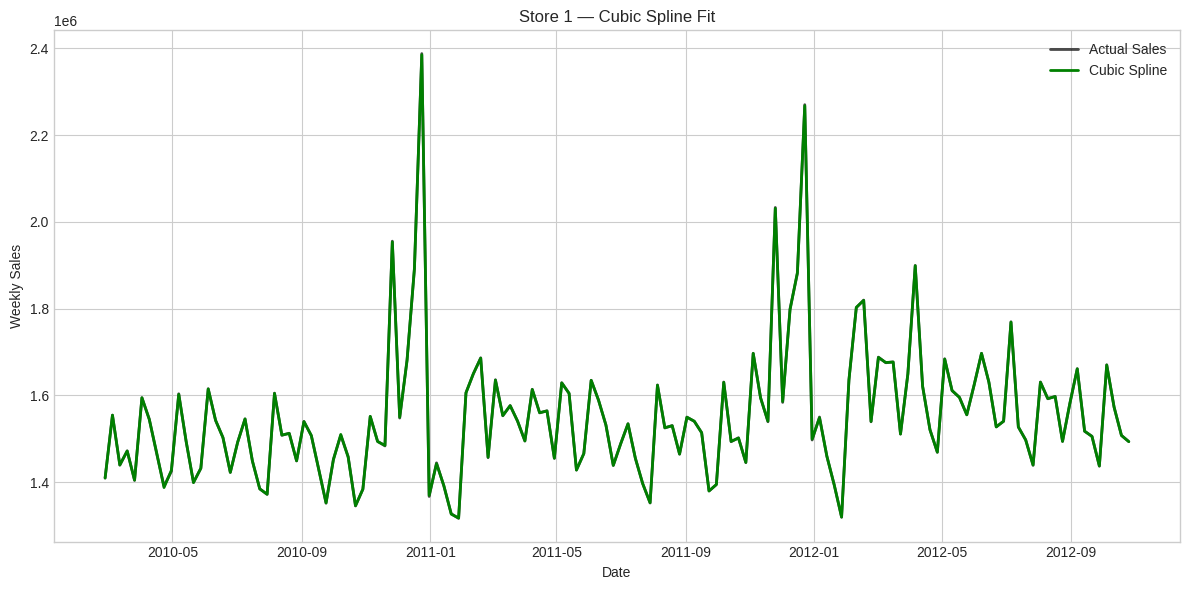

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(dates, y, label="Actual Sales", color="black", linewidth=2, alpha=0.7)
plt.plot(dates, y_spline, label="Cubic Spline", color="green", linewidth=2)

plt.title(f"Store {store_id_poly} — Cubic Spline Fit")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [55]:
comparison = poly_results_df.copy()
comparison = comparison[["degree", "mse", "cond"]]

# Add spline as "degree = 'spline'"
comparison = pd.concat([
    comparison,
    pd.DataFrame([{
        "degree": "spline",
        "mse": mse_spline,
        "cond": np.nan    # not applicable here
    }])
], ignore_index=True)

print("\nPolynomial vs Spline comparison:")
print(comparison)



Polynomial vs Spline comparison:
   degree           mse          cond
0       3  2.262196e+10  1.220579e+02
1       5  2.229042e+10  3.740597e+03
2      10  2.069089e+10  2.154363e+07
3      15  2.027506e+10  1.322556e+11
4  spline  1.000006e+06           NaN


In [56]:
import pandas as pd

final_table = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "XGBoost", "LSTM"],
    "RMSE": [rmse_arima, rmse_prophet, rmse_xgb, rmse_lstm],
    "MAE":  [mae_arima, mae_prophet, mae_xgb, mae_lstm]
})

final_table



Model          RMSE           MAE
0    ARIMA  43615.626595  37141.418606
1  Prophet  40426.939685  27848.532157
2  XGBoost  41147.231968  31203.246512
3     LSTM  90722.466280  61871.226562

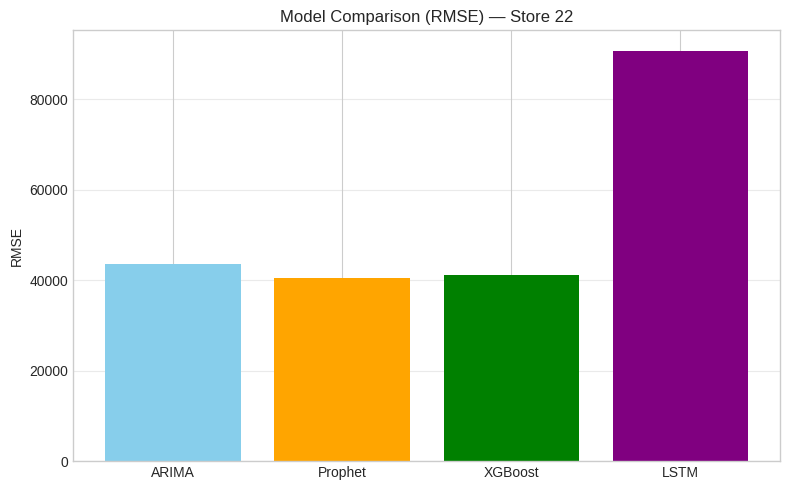

In [57]:
import matplotlib.pyplot as plt
# Showing Comparison of models
plt.figure(figsize=(8, 5))
plt.bar(final_table["Model"], final_table["RMSE"], color=['skyblue','orange','green','purple'])
plt.title(f"Model Comparison (RMSE) — Store {store_id}")
plt.ylabel("RMSE")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()


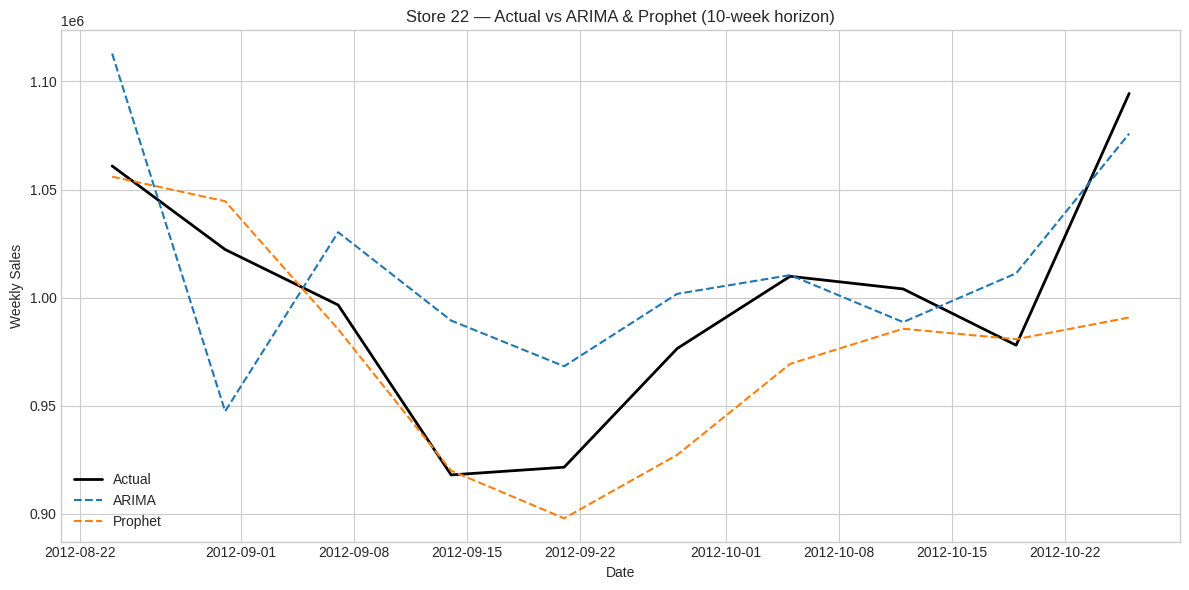

In [58]:
plt.figure(figsize=(12, 6))
# Actual VS Arima and Promphet
actual_10 = test["Weekly_Sales"].values
arima_10  = np.array(arima_forecast).flatten()
prophet_10 = np.array(prophet_forecast).flatten()

plt.plot(test.index, actual_10, label="Actual", linewidth=2, color="black")
plt.plot(test.index, arima_10, label="ARIMA", linestyle="--")
plt.plot(test.index, prophet_10, label="Prophet", linestyle="--")

plt.title(f"Store {store_id} — Actual vs ARIMA & Prophet (10-week horizon)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


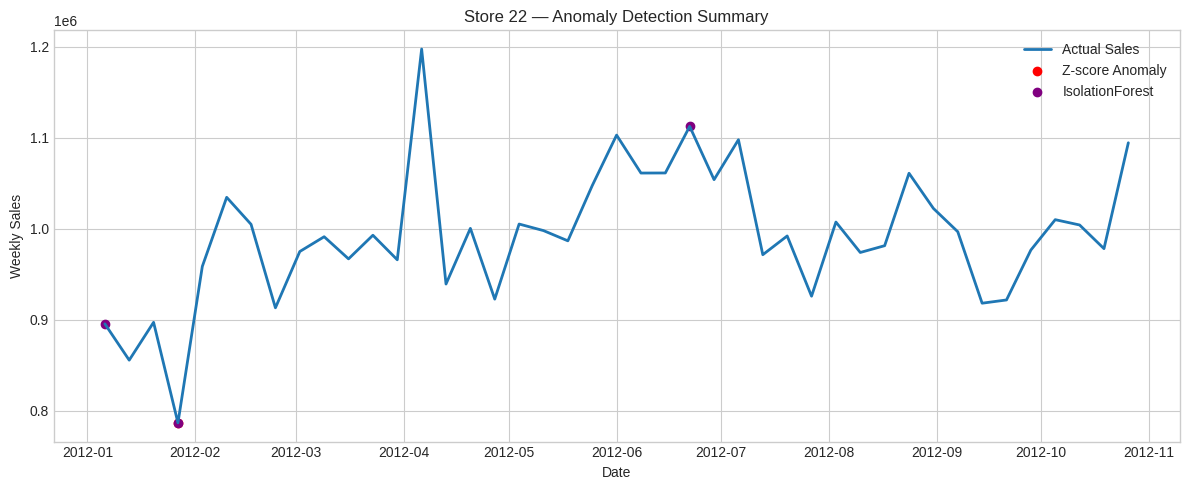

In [59]:
plt.figure(figsize=(12, 5))
plt.plot(test_ml["Date"], test_ml["Weekly_Sales"], label="Actual Sales", linewidth=2)

# z-score anomalies
anoms_z = test_ml[test_ml["Anomaly_z"] == 1]
plt.scatter(anoms_z["Date"], anoms_z["Weekly_Sales"], color="red", label="Z-score Anomaly")

# isolation forest anomalies
anoms_if = test_ml[test_ml["Anomaly_IF"] == 1]
plt.scatter(anoms_if["Date"], anoms_if["Weekly_Sales"], color="purple", label="IsolationForest")

plt.title(f"Store {store_id} — Anomaly Detection Summary")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


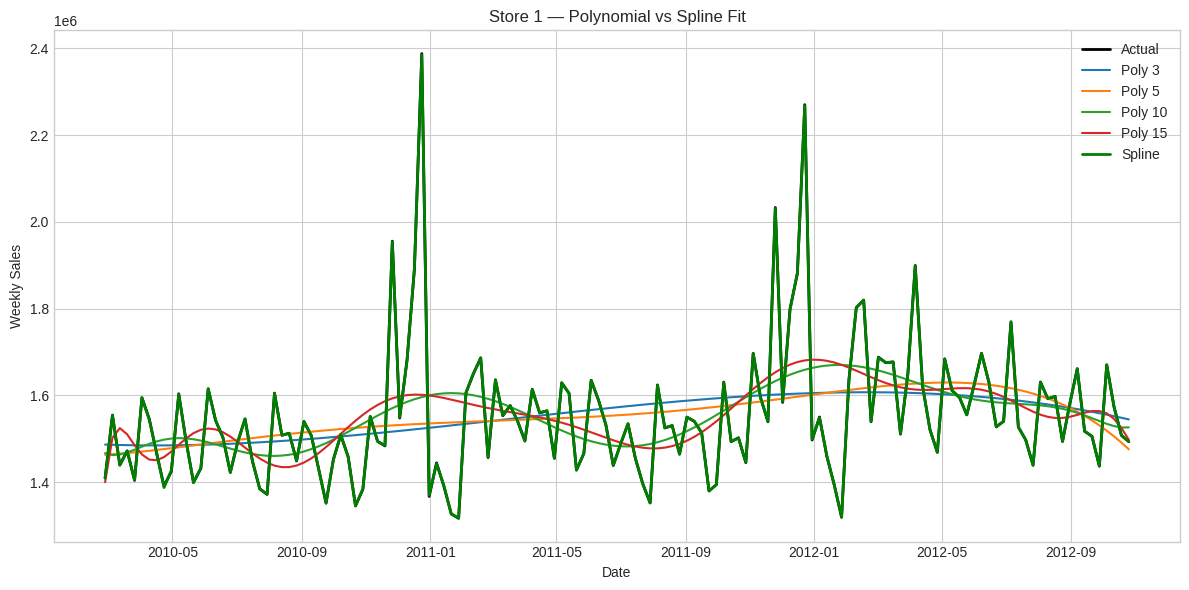

In [60]:
plt.figure(figsize=(12, 6))

plt.plot(dates, y, label="Actual", linewidth=2, color="black")

# poly predictions you saved earlier
for entry in poly_results:
    deg = entry["degree"]
    coeffs = np.polyfit(x_scaled, y, deg)
    poly = np.poly1d(coeffs)
    plt.plot(dates, poly(x_scaled), label=f"Poly {deg}")

# spline
plt.plot(dates, y_spline, label="Spline", linewidth=2, color="green")

plt.title(f"Store {store_id_poly} — Polynomial vs Spline Fit")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()
